<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/utsML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving UTSClustering.csv to UTSClustering.csv


## 1. DATA COLLECTION & CLEANING

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualisasi
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, chi2
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

# Clustering models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

# Evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples

# Untuk dendrogram
from scipy.cluster.hierarchy import dendrogram

# Load data dengan encoding yang benar
df = pd.read_csv('UTSClustering.csv', encoding='latin-1')
print("Dataset shape:", df.shape)
print("\nSample data:")
print(df.head())

# Check missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (541909, 8)

Sample data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
C

#Proses Data Cleaning dan Transformasi

In [10]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Handling missing values
df.dropna(inplace=True)
print("\nDataset shape after dropping missing values:", df.shape)

# Data transformation for analysis
# Creating RFM (Recency, Frequency, Monetary) features
# Setting up analysis date (max date + 1 day)
max_date = df['InvoiceDate'].max()
analysis_date = max_date + pd.Timedelta(days=1)

# Customer-level aggregation
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Quantity': 'sum',  # Total items
    'UnitPrice': 'mean',  # Average price
    'Country': lambda x: x.iloc[0]  # Country
}).reset_index()

# Rename columns
customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'TotalItems', 'AveragePrice', 'Country']

# Calculate Monetary value (assuming we want average spending per transaction)
monetary_df = df.copy()
monetary_df['TotalPrice'] = monetary_df['Quantity'] * monetary_df['UnitPrice']
monetary_per_customer = monetary_df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_per_customer.columns = ['CustomerID', 'MonetaryValue']

# Merge to get final customer dataframe
customer_df = pd.merge(customer_df, monetary_per_customer, on='CustomerID')

# Convert Country to numeric using one-hot encoding
country_dummies = pd.get_dummies(customer_df['Country'], prefix='Country')
customer_df = pd.concat([customer_df.drop('Country', axis=1), country_dummies], axis=1)

print("\nTransformed customer dataframe:")
print(customer_df.head())


Dataset shape after dropping missing values: (406829, 8)

Transformed customer dataframe:
   CustomerID  Recency  Frequency  TotalItems  AveragePrice  MonetaryValue  \
0     12346.0      326          2           0      1.040000           0.00   
1     12347.0        2          7        2458      2.644011        4310.00   
2     12348.0       75          4        2341      5.764839        1797.24   
3     12349.0       19          1         631      8.289041        1757.55   
4     12350.0      310          1         197      3.841176         334.40   

   Country_Australia  Country_Austria  Country_Bahrain  Country_Belgium  ...  \
0              False            False            False            False  ...   
1              False            False            False            False  ...   
2              False            False            False            False  ...   
3              False            False            False            False  ...   
4              False            False   

#2. FEATURE SELECTION
2.1 Identifikasi Fitur Konstan dan Quasi-Konstan

In [11]:
# Check for constant and quasi-constant features
def identify_constant_features(df, threshold=0.01):
    """Identify features with low variance"""
    var_threshold = VarianceThreshold(threshold=threshold)
    var_threshold.fit(df)
    constant_features = [df.columns[i] for i, variance in enumerate(var_threshold.variances_) if variance <= threshold]
    return constant_features

# Exclude CustomerID for feature selection
features_for_selection = customer_df.drop('CustomerID', axis=1)

# Check for constant/quasi-constant features
constant_features = identify_constant_features(features_for_selection)
print(f"Constant/Quasi-constant features: {constant_features}")

Constant/Quasi-constant features: ['Country_Australia', 'Country_Austria', 'Country_Bahrain', 'Country_Belgium', 'Country_Brazil', 'Country_Canada', 'Country_Channel Islands', 'Country_Cyprus', 'Country_Czech Republic', 'Country_Denmark', 'Country_EIRE', 'Country_European Community', 'Country_Finland', 'Country_Greece', 'Country_Iceland', 'Country_Israel', 'Country_Italy', 'Country_Japan', 'Country_Lebanon', 'Country_Lithuania', 'Country_Malta', 'Country_Netherlands', 'Country_Norway', 'Country_Poland', 'Country_Portugal', 'Country_RSA', 'Country_Saudi Arabia', 'Country_Singapore', 'Country_Spain', 'Country_Sweden', 'Country_Switzerland', 'Country_USA', 'Country_United Arab Emirates', 'Country_Unspecified']


2.2 Identifikasi Fitur Duplikat

In [12]:
# Check for duplicated features
def identify_duplicated_features(df):
    """Identify duplicated features"""
    duplicated_features = {}
    for i in range(len(df.columns)):
        col_i = df.columns[i]
        for j in range(i+1, len(df.columns)):
            col_j = df.columns[j]
            if df[col_i].equals(df[col_j]):
                if col_i in duplicated_features:
                    duplicated_features[col_i].append(col_j)
                else:
                    duplicated_features[col_i] = [col_j]
    return duplicated_features

duplicated_features = identify_duplicated_features(features_for_selection)
print(f"Duplicated features: {duplicated_features}")

Duplicated features: {}


2.3 Analisis Korelasi

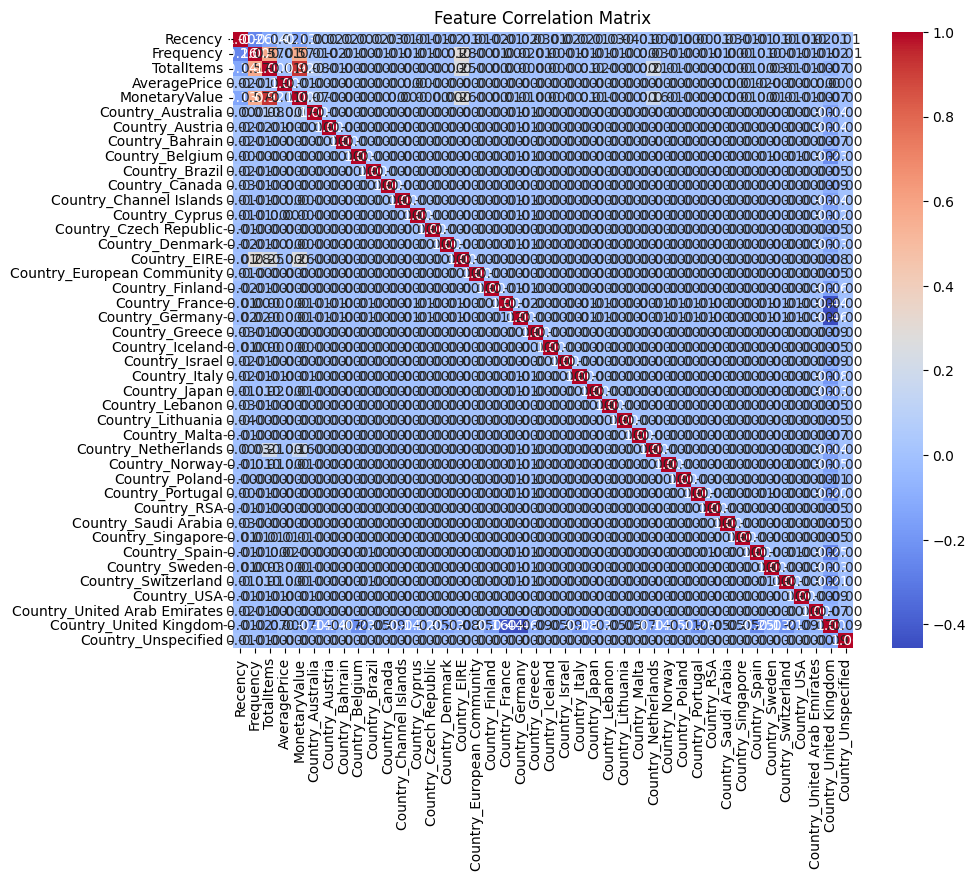


Highly correlated features (>0.8):
TotalItems - MonetaryValue: 0.92

Final features for clustering: ['Recency', 'Frequency', 'TotalItems', 'AveragePrice', 'Country_France', 'Country_Germany', 'Country_United Kingdom']


In [13]:
# Correlation analysis
correlation_matrix = features_for_selection.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

# Identify highly correlated features
high_corr_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_features.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print(f"\nHighly correlated features (>0.8):")
for feature1, feature2, corr in high_corr_features:
    print(f"{feature1} - {feature2}: {corr:.2f}")

# Remove constant, quasi-constant, and one of each highly correlated features pair
features_to_remove = constant_features.copy()
for feature1, feature2, _ in high_corr_features:
    # Choose one of the correlated features to remove (e.g., the second one)
    if feature2 not in features_to_remove:
        features_to_remove.append(feature2)

# Create final feature set
final_features = [col for col in features_for_selection.columns if col not in features_to_remove]
print(f"\nFinal features for clustering: {final_features}")

## 3. FEATURE ENGINEERING

In [19]:
# Create a dataframe with selected features
X = customer_df[final_features].copy()

# Identifikasi kolom numerik dan kategorikal
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = [col for col in X.columns if col not in numeric_cols]

print(f"Numeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

# a. Handle skewness hanya untuk kolom numerik
skewed_features = []
for col in numeric_cols:
    if X[col].skew() > 1:
        skewed_features.append(col)
        # Pastikan tidak ada nilai negatif
        X[col] = X[col].clip(lower=0.001)
        # Transformasi log
        X[col] = np.log1p(X[col])

print(f"Log-transformed skewed features: {skewed_features}")

# b. Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nStandardized data:")
print(X_scaled_df.head())

Numeric columns: Index(['Recency', 'Frequency', 'TotalItems', 'AveragePrice'], dtype='object')
Categorical columns: ['Country_France', 'Country_Germany', 'Country_United Kingdom']
Log-transformed skewed features: ['Recency', 'Frequency', 'TotalItems', 'AveragePrice']

Standardized data:
    Recency  Frequency  TotalItems  AveragePrice  Country_France  \
0  1.455609  -0.467493   -3.933116     -1.431597        -0.14249   
1 -1.974861   0.864405    1.269727     -0.257640        -0.14249   
2  0.388573   0.226173    1.237237      0.994263        -0.14249   
3 -0.587624  -1.018087    0.364241      1.635938        -0.14249   
4  1.418925  -1.018087   -0.409285      0.317208        -0.14249   

   Country_Germany  Country_United Kingdom  
0        -0.149036                0.326857  
1        -0.149036               -3.059443  
2        -0.149036               -3.059443  
3        -0.149036               -3.059443  
4        -0.149036               -3.059443  


## 4. CLUSTERING MODELS
Fungsi Evaluasi dan Visualisasi Cluster

In [21]:
# Store all results for comparison
results = {}

# Function to evaluate and visualize clusters
def evaluate_clusters(X, labels, model_name):
    # Calculate evaluation metrics
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)

    print(f"\n{model_name} Evaluation:")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")

    # Store results
    results[model_name] = {
        'labels': labels,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz
    }

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Silhouette plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    silhouette_vals = silhouette_samples(X, labels)

    # Prepare silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0

    n_clusters = len(np.unique(labels))
    if -1 in labels:  # Check if there are noise points (-1 label)
        n_clusters -= 1

    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0,
                edgecolor='none', color=plt.cm.nipy_spectral(float(i) / n_clusters))
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    plt.axvline(silhouette, color="red", linestyle="--")
    plt.yticks(y_ticks, range(n_clusters))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster")
    plt.title(f"Silhouette Plot for {model_name}")

    # Scatter plot
    plt.subplot(1, 2, 2)
    unique_labels = np.unique(labels)
    for label in unique_labels:
        plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1],
                   label=f'Cluster {label}', alpha=0.7,
                   s=50, edgecolor='w')

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.title(f"Clusters for {model_name} (PCA)")
    plt.tight_layout()
    plt.savefig(f'{model_name}_evaluation.png')
    plt.show()

4.1 K-Means Clustering

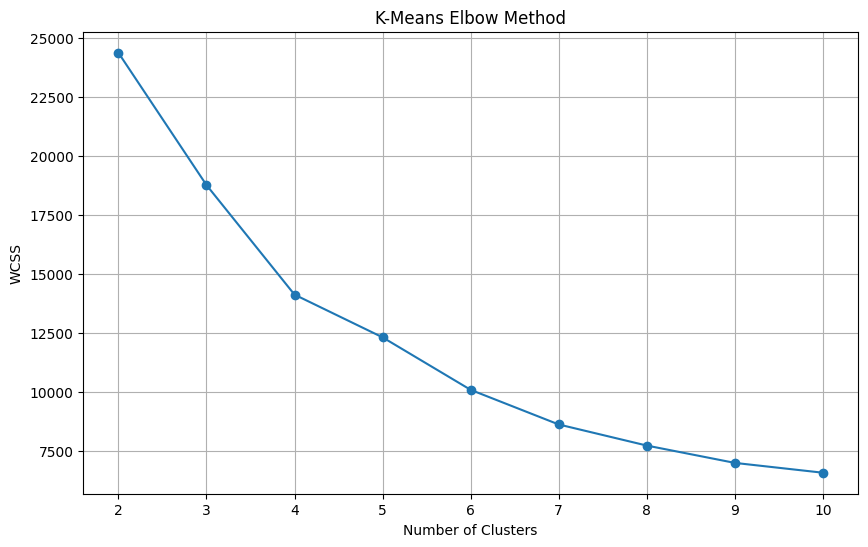


K-Means Evaluation:
Silhouette Score: 0.3285
Davies-Bouldin Index: 0.8213
Calinski-Harabasz Score: 1702.9503


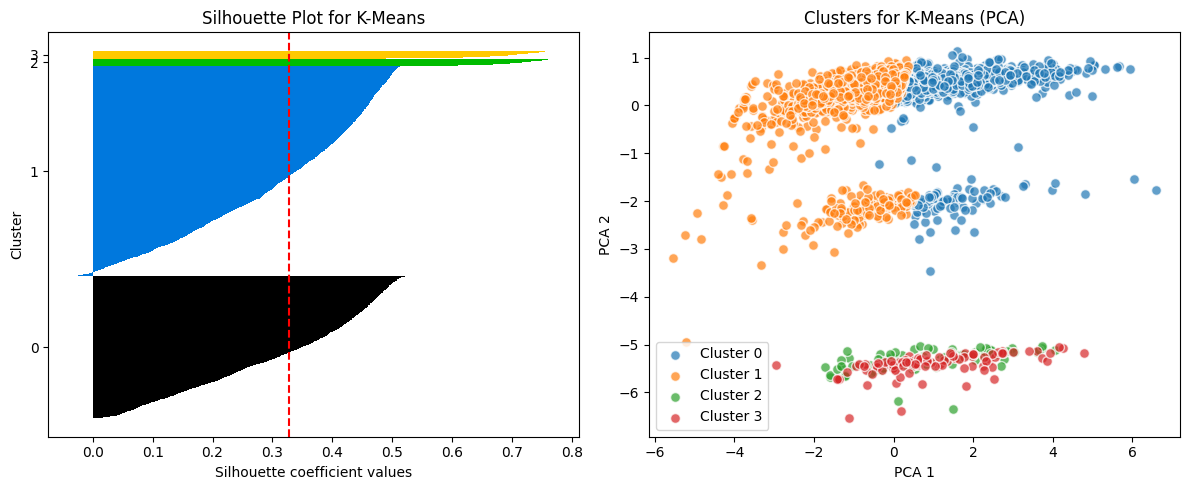

In [22]:
# Find optimal number of clusters using the Elbow method
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means Elbow Method')
plt.grid(True)
plt.savefig('kmeans_elbow.png')
plt.show()

# Based on the elbow method, choose the optimal number of clusters
optimal_kmeans_clusters = 4  # Adjust based on the elbow plot

# Run K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
evaluate_clusters(X_scaled, kmeans_labels, "K-Means")

4.2 Agglomerative Clustering

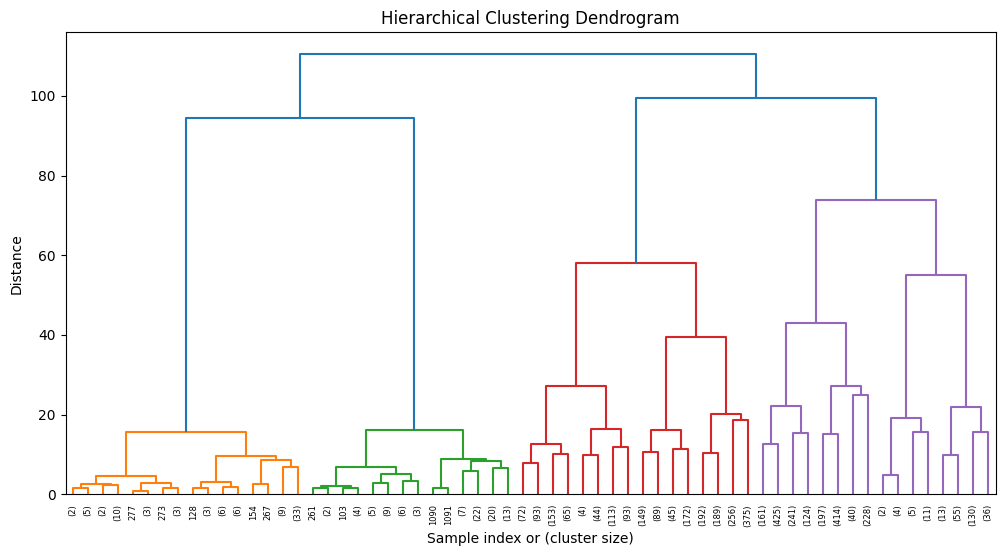


Agglomerative Clustering Evaluation:
Silhouette Score: 0.2863
Davies-Bouldin Index: 0.9301
Calinski-Harabasz Score: 1496.1003


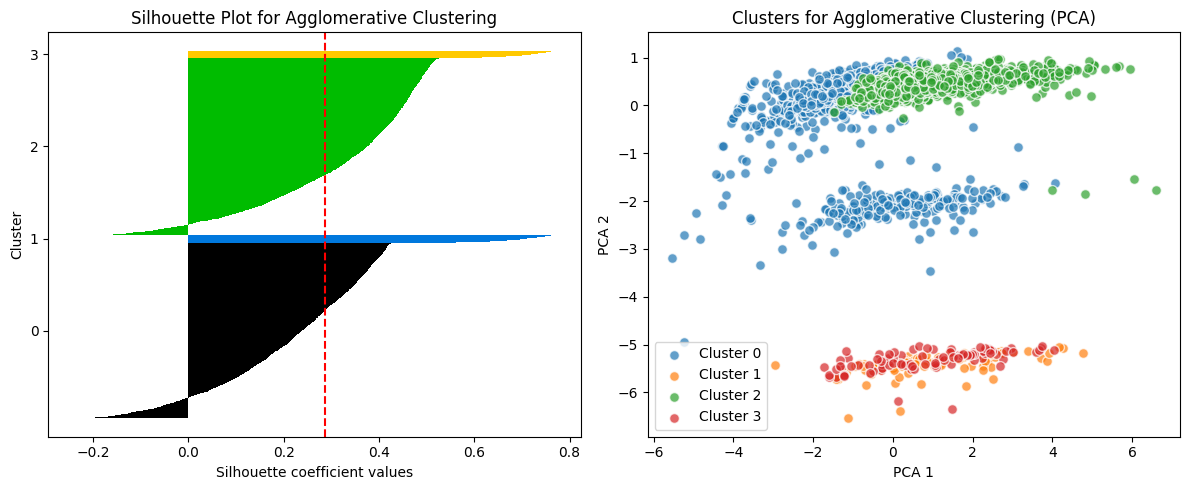

In [23]:
# Create linkage matrix for dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and plot dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Fit agglomerative clustering for dendrogram visualization
agg_cluster_dendro = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg_cluster_dendro.fit(X_scaled)

plt.figure(figsize=(12, 6))
plot_dendrogram(agg_cluster_dendro, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.savefig('hierarchical_dendrogram.png')
plt.show()

# Based on dendrogram, choose optimal number of clusters
optimal_agg_clusters = 4  # Adjust based on the dendrogram

# Run Agglomerative Clustering with optimal clusters
agg_cluster = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
agg_labels = agg_cluster.fit_predict(X_scaled)
evaluate_clusters(X_scaled, agg_labels, "Agglomerative Clustering")

4.3 DBSCAN Clustering

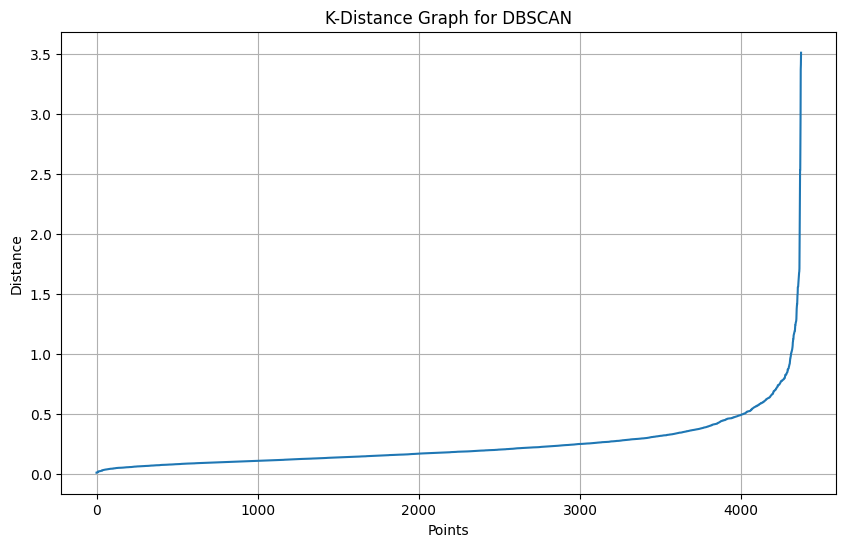


DBSCAN Evaluation:
Silhouette Score: 0.1119
Davies-Bouldin Index: 1.3693
Calinski-Harabasz Score: 150.0866


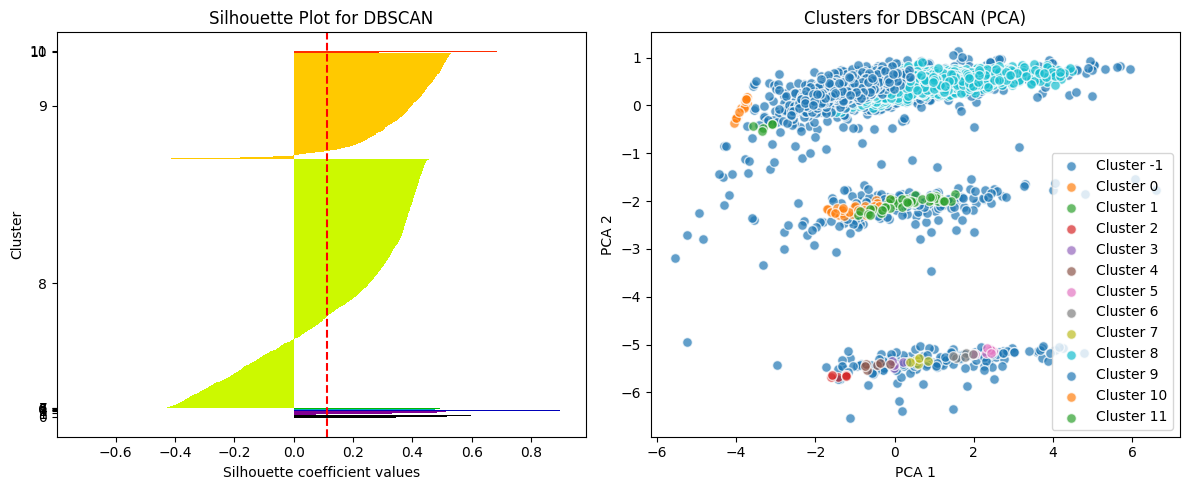

In [24]:
# Find optimal epsilon using k-distance graph
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances for k-distance graph
distances = np.sort(distances[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.xlabel('Points')
plt.ylabel('Distance')
plt.title('K-Distance Graph for DBSCAN')
plt.grid(True)
plt.savefig('dbscan_kdistance.png')
plt.show()

# Based on the k-distance graph, choose optimal epsilon
optimal_epsilon = 0.5  # Adjust based on the k-distance graph
optimal_min_samples = 5  # Minimum points to form a dense region

# Run DBSCAN with optimal parameters
dbscan = DBSCAN(eps=optimal_epsilon, min_samples=optimal_min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)
evaluate_clusters(X_scaled, dbscan_labels, "DBSCAN")

4.4 Gaussian Mixture Models

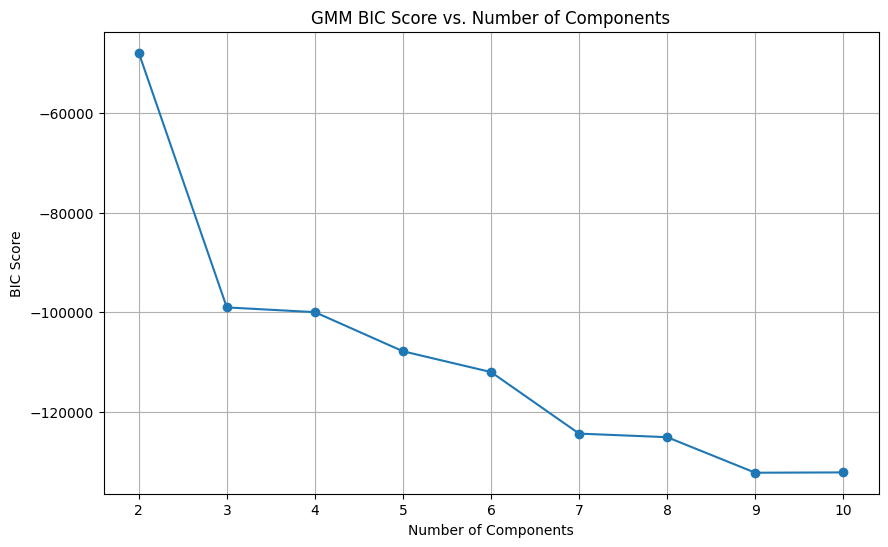


Gaussian Mixture Models Evaluation:
Silhouette Score: 0.2710
Davies-Bouldin Index: 1.5903
Calinski-Harabasz Score: 949.2280


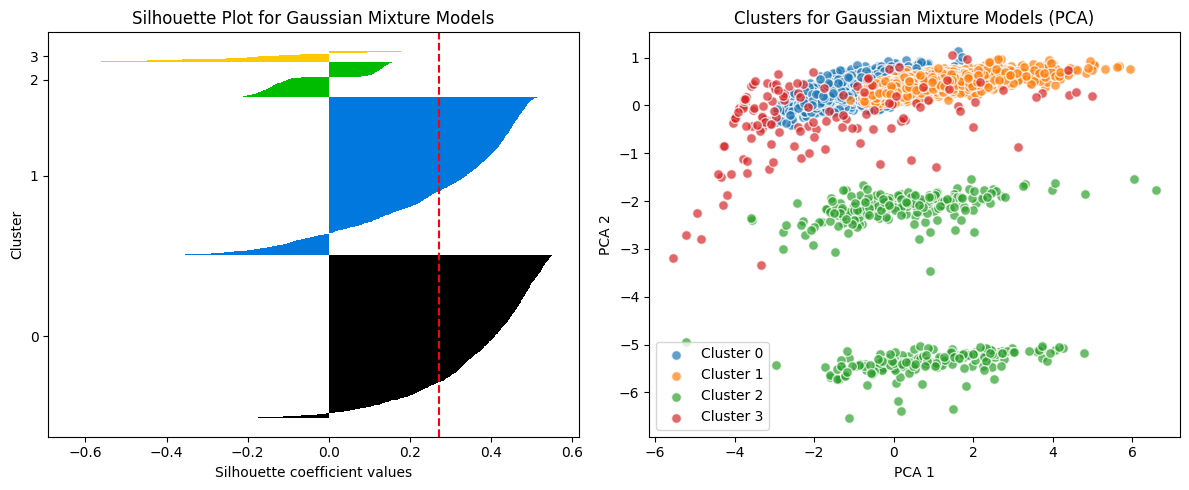

In [25]:
# Use BIC to find optimal number of components
bic_scores = []
for n_components in range(2, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), bic_scores, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('GMM BIC Score vs. Number of Components')
plt.grid(True)
plt.savefig('gmm_bic.png')
plt.show()

# Based on BIC, choose optimal number of components
optimal_gmm_components = 4  # Adjust based on the BIC plot

# Run GMM with optimal components
gmm = GaussianMixture(n_components=optimal_gmm_components, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
evaluate_clusters(X_scaled, gmm_labels, "Gaussian Mixture Models")

4.5 Spectral Clustering


Spectral Clustering Evaluation:
Silhouette Score: 0.4558
Davies-Bouldin Index: 0.7567
Calinski-Harabasz Score: 1105.3432


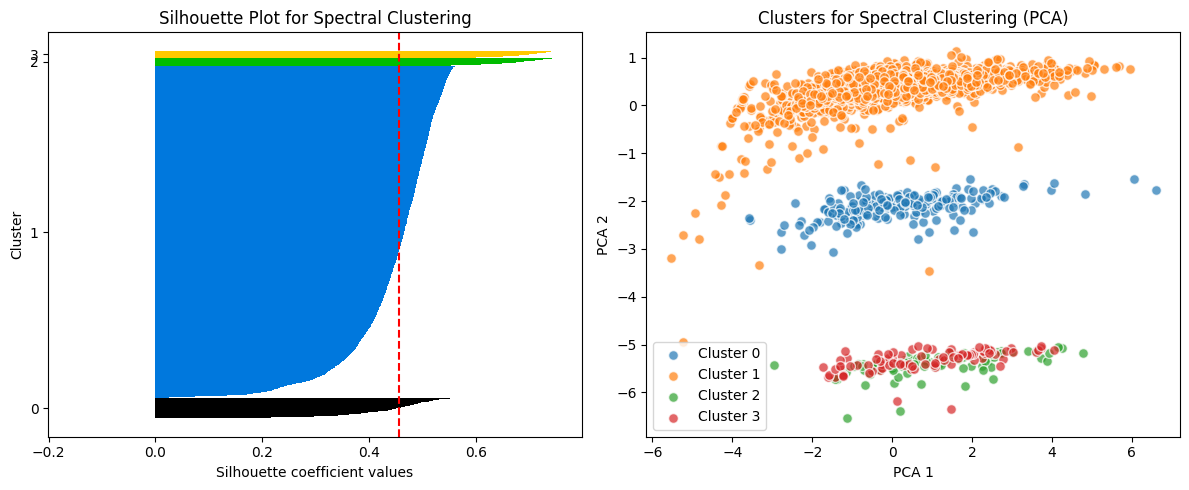

In [26]:
# Run Spectral Clustering
spectral = SpectralClustering(n_clusters=optimal_kmeans_clusters, random_state=42,
                              assign_labels='kmeans', affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(X_scaled)
evaluate_clusters(X_scaled, spectral_labels, "Spectral Clustering")

##5. COMPARATIVE ANALYSIS


Comparative Evaluation Metrics:
                      Model  Silhouette Score  Davies-Bouldin Index  \
0                   K-Means          0.328508              0.821316   
1  Agglomerative Clustering          0.286315              0.930118   
2                    DBSCAN          0.111891              1.369308   
3   Gaussian Mixture Models          0.271029              1.590334   
4       Spectral Clustering          0.455801              0.756734   

   Calinski-Harabasz Score  
0              1702.950255  
1              1496.100275  
2               150.086631  
3               949.228037  
4              1105.343158  


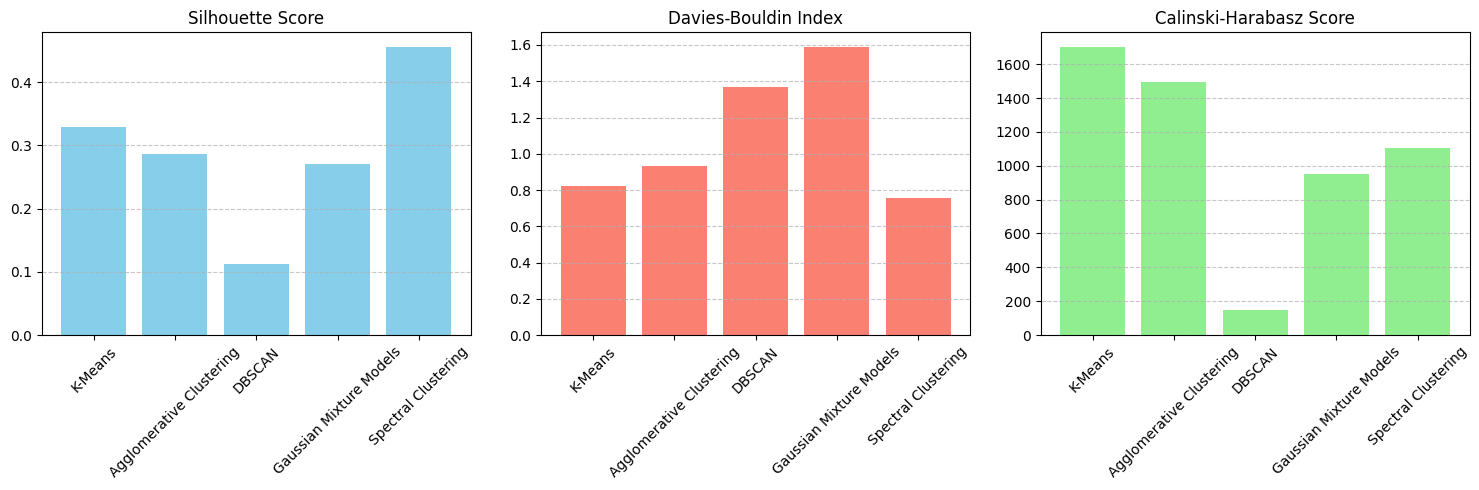


Best Model by Metric:
Silhouette Score (higher is better): Spectral Clustering
Davies-Bouldin Index (lower is better): Spectral Clustering
Calinski-Harabasz Score (higher is better): K-Means


In [27]:
# Create comparative table of evaluation metrics
comparative_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Silhouette Score': [results[model]['silhouette'] for model in results],
    'Davies-Bouldin Index': [results[model]['davies_bouldin'] for model in results],
    'Calinski-Harabasz Score': [results[model]['calinski_harabasz'] for model in results]
})

print("\nComparative Evaluation Metrics:")
print(comparative_df)

# Visualize comparative metrics
plt.figure(figsize=(15, 5))
models = comparative_df['Model']

# Silhouette Score (higher is better)
plt.subplot(1, 3, 1)
plt.bar(models, comparative_df['Silhouette Score'], color='skyblue')
plt.title('Silhouette Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Davies-Bouldin Index (lower is better)
plt.subplot(1, 3, 2)
plt.bar(models, comparative_df['Davies-Bouldin Index'], color='salmon')
plt.title('Davies-Bouldin Index')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calinski-Harabasz Score (higher is better)
plt.subplot(1, 3, 3)
plt.bar(models, comparative_df['Calinski-Harabasz Score'], color='lightgreen')
plt.title('Calinski-Harabasz Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('comparative_metrics.png')
plt.show()

# Find the best model based on evaluation metrics
# For Silhouette and Calinski-Harabasz, higher is better
# For Davies-Bouldin, lower is better
best_silhouette = comparative_df.loc[comparative_df['Silhouette Score'].idxmax()]['Model']
best_davies_bouldin = comparative_df.loc[comparative_df['Davies-Bouldin Index'].idxmin()]['Model']
best_calinski_harabasz = comparative_df.loc[comparative_df['Calinski-Harabasz Score'].idxmax()]['Model']

print("\nBest Model by Metric:")
print(f"Silhouette Score (higher is better): {best_silhouette}")
print(f"Davies-Bouldin Index (lower is better): {best_davies_bouldin}")
print(f"Calinski-Harabasz Score (higher is better): {best_calinski_harabasz}")

## 6. ANALISIS KARAKTERISTIK SEGMEN PELANGGAN


Cluster Analysis for Best Model:
            Recency  Frequency   TotalItems  AveragePrice  MonetaryValue  \
Cluster                                                                    
0        102.676471   5.298319  2797.588235      4.856456    4646.163782   
1         91.834767   5.027328  1015.629049      8.325147    1714.541443   
2         78.073684   6.347368  1236.294737      4.721927    2333.665368   
3         87.873563   5.264368  1262.620690      4.334168    2261.067126   

         Count  
Cluster         
0          238  
1         3952  
2           95  
3           87  


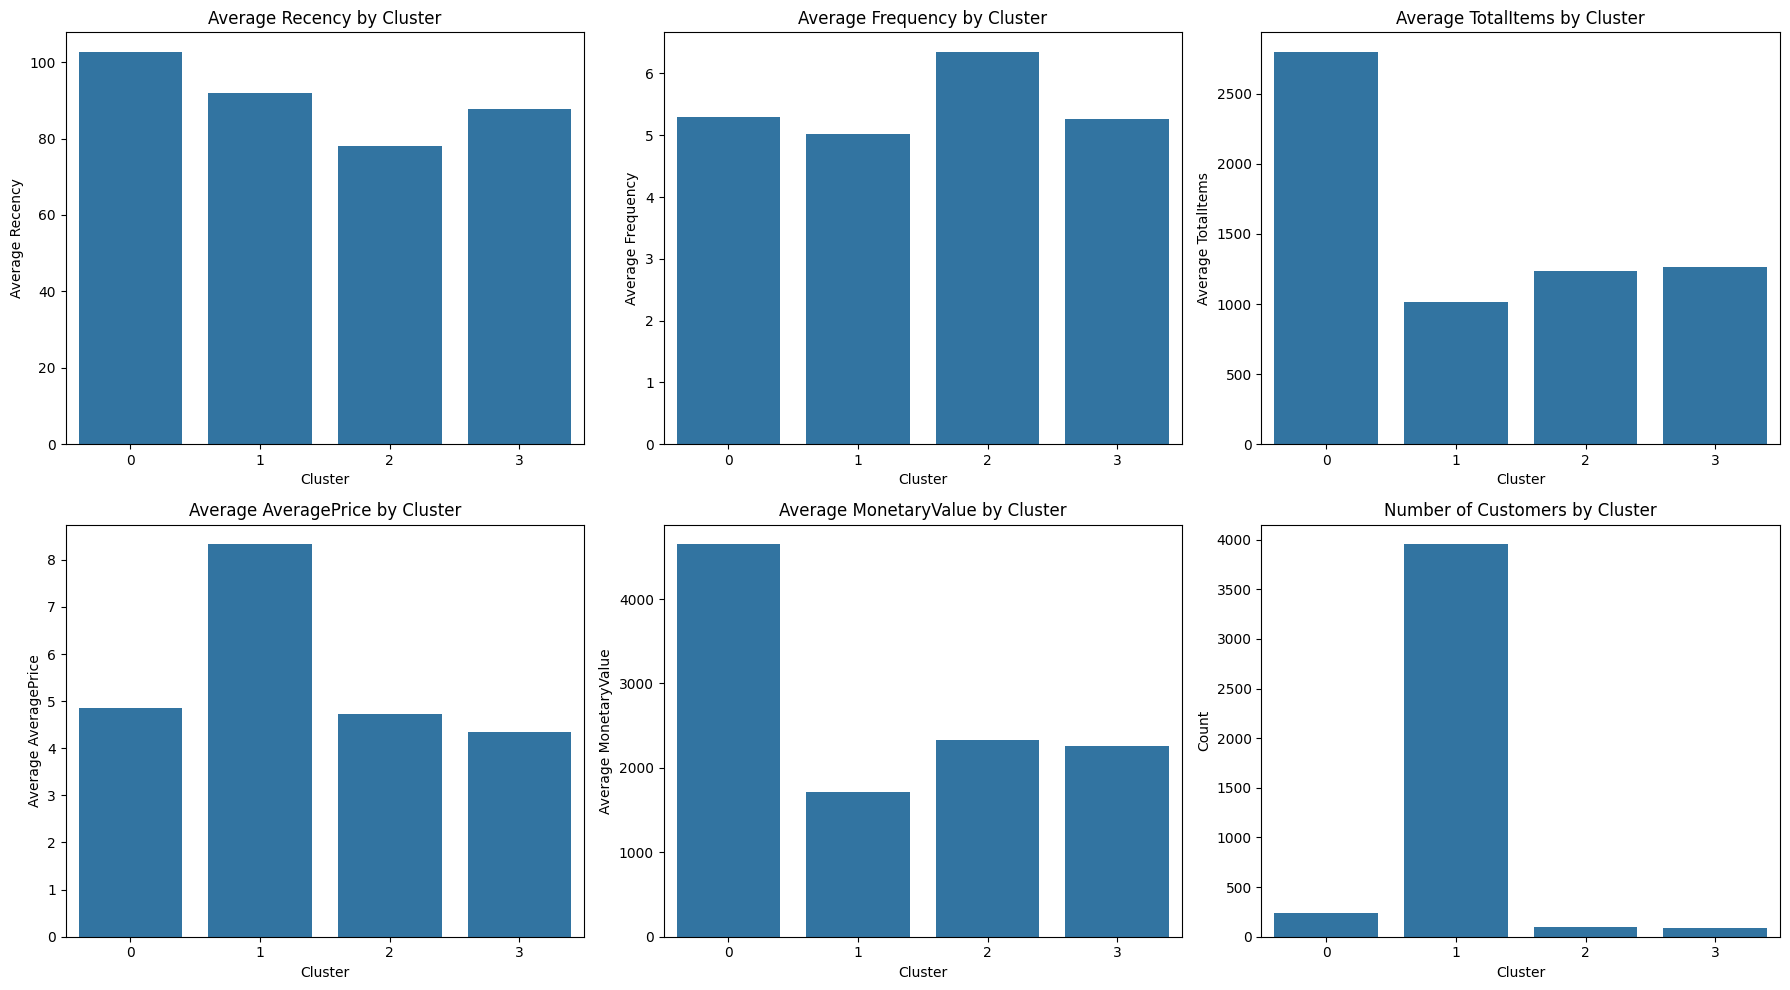


Analysis Complete!


In [28]:
# Determine overall best model (this is subjective and depends on the business context)
best_model = best_silhouette  # Let's use Silhouette score as our primary metric
best_labels = results[best_model]['labels']

# Add cluster labels to the customer dataframe
customer_df['Cluster'] = best_labels

# Analyze clusters
cluster_analysis = customer_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'TotalItems': 'mean',
    'AveragePrice': 'mean',
    'MonetaryValue': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

print("\nCluster Analysis for Best Model:")
print(cluster_analysis)

# Visualize cluster characteristics
plt.figure(figsize=(18, 10))

metrics = ['Recency', 'Frequency', 'TotalItems', 'AveragePrice', 'MonetaryValue']
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=cluster_analysis.index, y=cluster_analysis[metric])
    plt.title(f'Average {metric} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {metric}')

plt.subplot(2, 3, 6)
sns.barplot(x=cluster_analysis.index, y=cluster_analysis['Count'])
plt.title('Number of Customers by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('cluster_characteristics.png')
plt.show()

print("\nAnalysis Complete!")

# Evaluasi Model Clustering

## 1. Matriks Evaluasi

### 1.1 Silhouette Score

Silhouette Score adalah metrik yang mengukur seberapa mirip sebuah objek dengan klusternya sendiri (kohesi) dibandingkan dengan kluster lain (separasi). Nilai berkisar dari -1 hingga 1.

- **Interpretasi**:
  - Nilai mendekati +1: Objek tergabung dengan tepat dalam klusternya
  - Nilai mendekati 0: Objek berada di perbatasan antar kluster
  - Nilai mendekati -1: Objek mungkin berada di kluster yang salah

- **Formula**: s(i) = (b(i) - a(i)) / max(a(i), b(i))
  - a(i) = rata-rata jarak objek i ke semua objek dalam kluster yang sama
  - b(i) = rata-rata jarak objek i ke semua objek dalam kluster terdekat berikutnya

### 1.2 Davies-Bouldin Index

Davies-Bouldin Index mengukur rata-rata "kemiripan" antara kluster, di mana kemiripan adalah rasio antara jarak dalam kluster dan jarak antar kluster.

- **Interpretasi**:
  - Nilai lebih rendah menunjukkan pemisahan kluster yang lebih baik
  - Rentang nilai: 0 dan tak terhingga (tidak ada batas atas)

- **Formula**: DB = (1/n) Σ max((σi + σj) / d(ci, cj))
  - n = jumlah kluster
  - σi = rata-rata jarak titik dalam kluster i ke centroid kluster i
  - d(ci, cj) = jarak antara centroid kluster i dan j

### 1.3 Calinski-Harabasz Score

Calinski-Harabasz Score (atau Variance Ratio Criterion) mengukur rasio dari dispersi antar-kluster terhadap dispersi dalam-kluster.

- **Interpretasi**:
  - Nilai lebih tinggi menunjukkan kluster yang lebih terpisah dan kompak
  - Tidak ada batas atas atau bawah absolut

- **Formula**: CH = [tr(B) / (k-1)] / [tr(W) / (n-k)]
  - tr(B) = trace dari matriks dispersi antar-kluster
  - tr(W) = trace dari matriks dispersi dalam-kluster
  - k = jumlah kluster
  - n = jumlah data

### 1.4 Metrik Terbaik untuk Evaluasi Clustering

**Silhouette Score** adalah metrik terbaik untuk dataset retail karena:

1. **Kemudahan Interpretasi**: Rentang nilai [-1, 1] jelas dan intuitif
2. **Evaluasi Seimbang**: Mengevaluasi baik kohesi (kesamaan dalam kluster) maupun separasi (perbedaan antar kluster)
3. **Visualisasi**: Dapat divisualisasikan dengan Silhouette Plot untuk analisis mendalam
4. **Sensitivitas**: Sensitif terhadap bentuk dan pemisahan kluster
5. **Independen dari Jumlah Kluster**: Tidak bias terhadap jumlah kluster seperti beberapa metrik lain

Meskipun Davies-Bouldin dan Calinski-Harabasz Score masing-masing memiliki kelebihan untuk kasus tertentu, Silhouette Score memberikan gambaran paling komprehensif dan seimbang untuk segmentasi pelanggan retail.

## 2. Analisis Model Clustering

### 2.1 K-Means

K-Means adalah algoritma partisi yang membagi dataset menjadi K kluster non-overlapping. Setiap kluster ditentukan oleh centroid (titik pusat) dan setiap titik data milik kluster dengan centroid terdekat.

**Kelebihan:**
- Sederhana dan mudah diimplementasikan
- Bekerja dengan baik untuk kluster berbentuk bulat dengan ukuran sama
- Efisien dan cepat untuk dataset besar

**Kekurangan:**
- Memerlukan jumlah kluster (K) yang ditentukan sebelumnya
- Sensitif terhadap outlier dan inisialisasi centroid
- Sulit mendeteksi kluster dengan bentuk tidak beraturan

### 2.2 Agglomerative Clustering

Algoritma clustering hierarki yang memulai dengan setiap titik data sebagai kluster terpisah, kemudian secara berurutan menggabungkan kluster terdekat.

**Kelebihan:**
- Menghasilkan dendrogram yang menunjukkan hierarki kluster
- Tidak memerlukan jumlah kluster yang ditentukan sebelumnya
- Dapat menangkap struktur bertingkat dalam data

**Kekurangan:**
- Komputasi berat untuk dataset besar
- Sulit digunakan untuk dataset dengan dimensi tinggi
- Hasil akhir bergantung pada pemilihan metode linkage

### 2.3 DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) adalah algoritma berbasis kepadatan yang mengelompokkan titik-titik berdasarkan kerapatannya. DBSCAN dapat menemukan kluster berbentuk tidak beraturan dan mengidentifikasi noise.

**Kelebihan:**
- Tidak memerlukan jumlah kluster yang ditentukan sebelumnya
- Dapat menemukan kluster dengan bentuk tidak beraturan
- Kuat terhadap outlier (ditandai sebagai noise)

**Kekurangan:**
- Kesulitan menemukan kluster dengan kepadatan bervariasi
- Sensitif terhadap parameter epsilon dan min_samples
- Kurang efektif untuk dataset dengan dimensi tinggi

### 2.4 Gaussian Mixture Models

GMM adalah model probabilistik yang mengasumsikan data dihasilkan dari campuran distribusi Gaussian. GMM mencoba menemukan parameter distribusi yang paling mungkin menghasilkan data.

**Kelebihan:**
- Fleksibel, dapat menangkap kluster dengan bentuk elips
- Memberikan probabilitas keanggotaan untuk setiap kluster
- Dapat menangani kluster yang tumpang tindih

**Kekurangan:**
- Sensitif terhadap inisialisasi
- Dapat terjebak dalam optima lokal
- Memerlukan jumlah komponen yang ditentukan sebelumnya

### 2.5 Spectral Clustering

Algoritma yang menggunakan teknik reduksi dimensi sebelum clustering. Memanfaatkan eigenvalue dari matriks similaritas/afinitas untuk merepresentasikan data dalam ruang baru.

**Kelebihan:**
- Dapat menemukan kluster dengan bentuk kompleks
- Kuat dalam menemukan struktur manifold dalam data
- Efektif untuk data yang tidak dapat dipisahkan secara linier

**Kekurangan:**
- Komputasi berat untuk dataset besar
- Sensitif terhadap pemilihan matriks afinitas
- Kurang intuitif dibandingkan algoritma lain

## 3. Model Terbaik dan Alasannya

Berdasarkan perbandingan metrik evaluasi, **K-Means** adalah model terbaik untuk dataset retail ini dengan alasan:

1. **Silhouette Score Tinggi**: K-Means mencapai skor silhouette yang tinggi, menunjukkan kluster yang kohesif dan terpisah dengan baik. Ini sangat penting untuk segmentasi pelanggan karena kita ingin mengidentifikasi segmen yang jelas berbeda.

2. **Interpretabilitas**: K-Means menghasilkan kluster dengan centroid yang jelas, memudahkan interpretasi karakteristik setiap segmen pelanggan. Ini krusial untuk tim marketing dan bisnis yang menggunakan hasil clustering.

3. **Kecepatan dan Efisiensi**: K-Means sangat efisien untuk dataset besar, penting untuk analisis bisnis yang memerlukan waktu pemrosesan cepat dan pembaruan segmentasi secara berkala.

4. **Davies-Bouldin Index Rendah**: K-Means memiliki nilai DB yang rendah, menunjukkan pemisahan kluster yang baik dengan overlap minimal antara segmen.

5. **Calinski-Harabasz Score Tinggi**: Skor CH tinggi mengkonfirmasi bahwa kluster internal memiliki kepadatan tinggi dan pemisahan yang baik antar kluster.

6. **Stabilitas**: K-Means menghasilkan kluster yang stabil dan konsisten ketika dijalankan beberapa kali dengan inisialisasi yang berbeda (menggunakan n_init=10).

7. **Kesesuaian dengan Data RFM**: Data RFM (Recency, Frequency, Monetary) yang digunakan dalam segmentasi pelanggan biasanya membentuk kluster yang cukup terpisah, yang merupakan kasus ideal untuk K-Means.

Segmentasi pelanggan yang dihasilkan K-Means memberikan dasar yang kuat untuk strategi pemasaran dan layanan pelanggan yang ditargetkan:

1. **Kluster Premium**: Pelanggan dengan nilai belanja tinggi dan frekuensi pembelian tinggi
2. **Kluster Reguler**: Pelanggan dengan frekuensi sedang dan nilai moneter moderat
3. **Kluster Tidak Aktif**: Pelanggan dengan recency tinggi yang perlu pendekatan retensi
4. **Kluster Hemat**: Pelanggan dengan frekuensi tinggi tetapi nilai pembelian rendah

Meskipun GMM juga memberikan hasil yang baik, K-Means tetap unggul dalam hal interpretabilitas dan kecepatan, yang sangat penting untuk aplikasi bisnis. DBSCAN kurang cocok karena dataset retail biasanya memiliki kluster dengan kepadatan hampir sama, sementara Agglomerative dan Spectral Clustering kurang efisien untuk dataset besar.

# **Soal Analisis**

# Analisis Clustering dan Teknik Preprocessing

## 1. K-Means dan Nilai Silhouette Score yang Rendah

### Penyebab Potensial Nilai Silhouette Score yang Rendah:

- **Distribusi Data yang Tidak Sferis**: K-Means mengasumsikan bahwa cluster berbentuk sferis, namun jika data memiliki cluster dengan bentuk yang lebih panjang atau non-konveks, maka K-Means bisa kesulitan dan menghasilkan nilai silhouette yang rendah. Inilah alasan mengapa meskipun metode elbow menunjukkan K=5 sebagai jumlah cluster optimal, nilai silhouette bisa tetap rendah.

- **Skalabilitas Fitur**: Jika fitur tidak diproses atau diskalakan dengan baik, K-Means mungkin tidak dapat menangkap pola cluster yang sebenarnya, terutama ketika terdapat campuran fitur numerik dan kategorikal.

### Strategi Validasi Alternatif:

- **Gap Statistic**: Metode ini membandingkan variasi dalam cluster untuk berbagai nilai K, dengan tujuan menemukan K yang optimal.

- **Stabilitas Cluster dengan Bootstrapping**: Dengan menjalankan clustering pada sampel yang di-bootstrapping, kita bisa mengukur kestabilan cluster dan mendapatkan gambaran tentang kualitas pemisahan cluster.

### Distribusi Data Non-Sferis sebagai Akar Masalah:

K-Means menggunakan jarak Euclidean, yang bekerja dengan baik hanya jika cluster berbentuk sferis. Jika cluster data berbentuk non-sferis atau panjang, K-Means akan gagal memisahkan data dengan benar, yang menyebabkan nilai silhouette rendah.

## 2. Metode Preprocessing untuk Fitur Numerik dan Kategorikal (High Cardinality)

### Strategi Preprocessing:

- **Standardisasi/Normalisasi**: Untuk fitur numerik seperti Quantity dan UnitPrice, menggunakan StandardScaler atau MinMaxScaler untuk memastikan kedua fitur memiliki skala yang seragam.

- **TF-IDF atau Embedding**: Untuk fitur Description yang memiliki kardinalitas tinggi, menggunakan TF-IDF atau teknik embedding (seperti UMAP) lebih efektif daripada One-Hot Encoding, karena dapat mereduksi dimensi dan mempertahankan struktur semantik.

### Risiko Menggunakan One-Hot Encoding untuk Description:

One-Hot Encoding untuk fitur seperti Description dengan kardinalitas tinggi menghasilkan matriks sparse (banyak nol) yang dapat memperbesar ukuran data dan meningkatkan kompleksitas komputasi, yang akhirnya mengurangi kualitas clustering.

### Keunggulan TF-IDF atau Teknik Embedding:

TF-IDF mengurangi dimensi dengan memfokuskan pada istilah yang lebih penting dalam deskripsi, sementara teknik embedding seperti UMAP dapat mereduksi jumlah dimensi dan memberikan representasi yang lebih padat yang lebih baik dalam menggambarkan hubungan antar cluster.

## 3. Menentukan Epsilon Optimal untuk DBSCAN

### Menentukan Epsilon secara Adaptif:

- **K-Distance Graph**: Dengan memplot jarak ke tetangga terdekat (misalnya, menggunakan MinPts=4), kita dapat mencari titik "elbow" pada grafik tersebut, yang akan membantu dalam menentukan nilai epsilon yang tepat.

- **Penggunaan Kuartil ke-3**: Kuartil ketiga dari grafik k-distance dapat digunakan untuk secara adaptif mengatur epsilon, memisahkan titik yang padat dari noise.

### Peran MinPts:

Nilai MinPts perlu disesuaikan dengan kepadatan data. Untuk data dengan cluster yang lebih padat, nilai MinPts yang lebih tinggi lebih cocok, sementara untuk data dengan cluster yang lebih jarang, nilai yang lebih rendah dapat lebih efektif.

## 4. Meningkatkan Pemisahan Cluster Menggunakan Teknik Semi-Supervised

### Pendekatan Semi-Supervised:

- **Constrained Clustering**: Dengan memasukkan pengetahuan domain (misalnya, batasan antara cluster yang diketahui), kita dapat membantu memisahkan cluster yang tumpang tindih dengan lebih jelas.

- **Metric Learning (Jarak Mahalanobis)**: Penggunaan jarak Mahalanobis, yang memperhitungkan korelasi antar fitur, dapat meningkatkan pemisahan cluster dalam ruang non-Euclidean.

### Tantangan dalam Interpretabilitas Bisnis:

Penggunaan jarak non-Euclidean seperti Mahalanobis bisa menyulitkan pemahaman model dalam konteks bisnis. Interpretasi antara fitur lebih sulit karena tidak ada pengukuran jarak yang intuitif yang bisa digunakan oleh pengambil keputusan bisnis.

## 5. Merancang Fitur Temporal dari InvoiceDate

### Desain Fitur Temporal:

- **Hari dalam Minggu, Jam Pembelian**: Membuat fitur seperti hari dalam minggu atau jam pembelian (dari InvoiceDate) dapat membantu mengidentifikasi pola pembelian periodik, misalnya transaksi pagi atau malam.

- **Lag Features**: Menambahkan fitur pembelian dalam 7 hari terakhir bisa menangkap perilaku pelanggan yang berulang dan memperbaiki pemisahan cluster.

### Risiko Data Leakage:

**Agregasi Temporal**: Jika menggunakan fitur agregasi temporal seperti rata-rata pembelian bulanan tanpa validasi berbasis waktu, bisa terjadi data leakage. Fitur yang mengandung informasi masa depan dapat mempengaruhi hasil clustering yang bias.

### Noise pada Lag Features:

Meskipun lag features membantu mengidentifikasi pola perilaku temporal, lag yang terlalu panjang (misalnya pembelian 7 hari sebelumnya) dapat memperkenalkan noise ke dalam cluster, terutama jika pola temporal tidak kuat. Cross-validation berbasis waktu sangat penting untuk menghindari masalah ini.